In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

rootdir = '/mnt/c/Jupyter/notebooks/CS391L_MachineLearning/HW4/data_GP/AG/'

file_list = []
for subdir,dirs,files in os.walk(rootdir):
    if files:
        file_list.append(os.path.join(subdir,files[0]))
    
file_list

['/mnt/c/Jupyter/notebooks/CS391L_MachineLearning/HW4/data_GP/AG/block1-UNWEIGHTED-SLOW-NONDOMINANT-RANDOM/20161213203046-59968-right-speed_0.500.csv',
 '/mnt/c/Jupyter/notebooks/CS391L_MachineLearning/HW4/data_GP/AG/block2-UNWEIGHTED-SLOW-NONDOMINANT-RANDOM/20161213204004-59968-right-speed_0.500.csv',
 '/mnt/c/Jupyter/notebooks/CS391L_MachineLearning/HW4/data_GP/AG/block3-UNWEIGHTED-SLOW-NONDOMINANT-RANDOM/20161213204208-59968-right-speed_0.500.csv',
 '/mnt/c/Jupyter/notebooks/CS391L_MachineLearning/HW4/data_GP/AG/block4-UNWEIGHTED-SLOW-NONDOMINANT-RANDOM/20161213204925-59968-right-speed_0.500.csv',
 '/mnt/c/Jupyter/notebooks/CS391L_MachineLearning/HW4/data_GP/AG/block5-UNWEIGHTED-SLOW-NONDOMINANT-RANDOM/20161213210121-59968-right-speed_0.500.csv']

We are only interested in the x, y, z, and c points for a sensor at position p. 

In [3]:
# sensor 15 = back of right hand
p = str(15)
selection = [p+'_x',p+'_y',p+'_z',p+'_c']

In [4]:
# create empty array to hold 5 instances of data that have 1030 datapoints for x,y,z,c (4) 
blocks = np.empty([5,1030,4])

for i,filename in enumerate(file_list):
    blocks[i,:,:] = np.array(pd.read_csv(filename)[selection])

blocks.shape

(5, 1030, 4)

# Data Cleaning

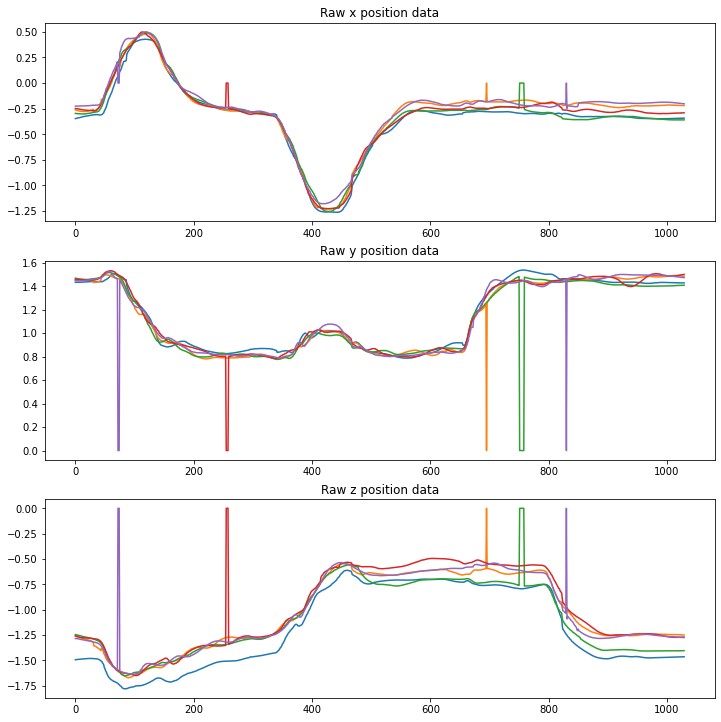

In [5]:
t = range(0,1030)
pos = ['x','y','z']

plt.figure(figsize=(12, 5))
for i in range(3):
    # i=0=x; i=1=y; i=2=z
    plt.subplot(3, 1, i + 1)
    plt.subplots_adjust(top=2)
    
    for block in range(5):    
        plt.plot(t, blocks[block,:,i])
        
    plt.title(f'Raw {pos[i]} position data')

In [6]:
# clean data: block[#][r][_] = block[#][r-1][_] + 0.5(block[#][r-1][_] - block[#][r-2][_])
for block in blocks: 
    for r in range(2,len(block)):
        if block[r][3] < 0: # 3 = c
            block[r,:] = block[r-1,:] + 0.5*(block[r-1,:] - block[r-2,:])

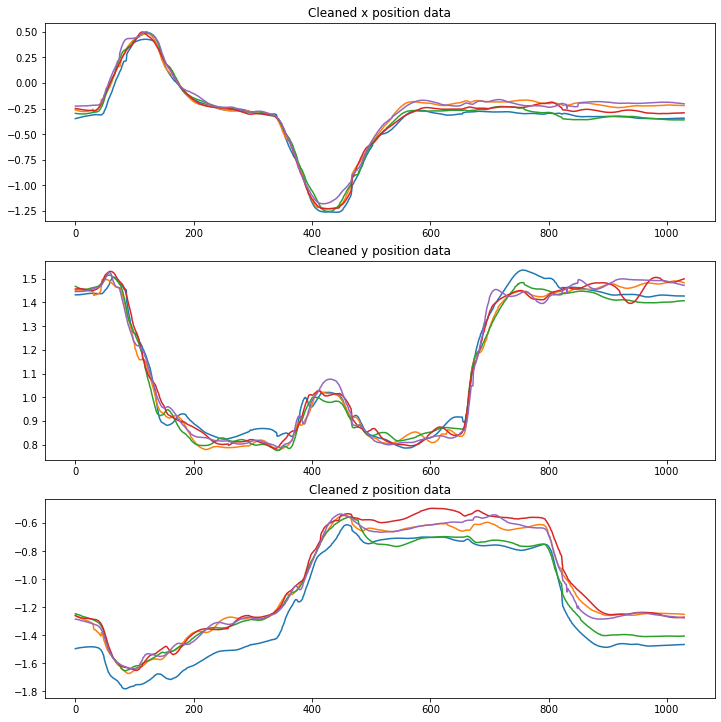

In [7]:
t = range(0,1030)
pos = ['x','y','z']

plt.figure(figsize=(12, 5))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.subplots_adjust(top=2)
    
    for block in range(5):    
        plt.plot(t, blocks[block,:,i])
        
    plt.title(f'Cleaned {pos[i]} position data')

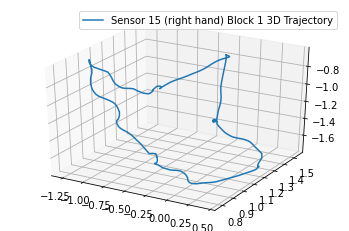

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

t = range(0,1030)
x = blocks[0,:,0]
y = blocks[0,:,1]
z = blocks[0,:,2]

ax.plot(x, y, z, label='Sensor 15 (right hand) Block 1 3D Trajectory')
ax.legend()

plt.show()

# Gaussian Process

## Functions

In [9]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    '''
    Source: https://github.com/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes_util.py
    '''
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(cov)
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

def get_pred(t_s, t_train, y_train, sigma):
    sigma_f = sigma[0]
    sigma_l = sigma[1]
    sigma_n = sigma[2]
    
    rbf = ConstantKernel(sigma_f) * RBF(length_scale=sigma_l)
    gpr = GaussianProcessRegressor(kernel=rbf, alpha=sigma_n**2, n_restarts_optimizer=8)
    gpr.fit(t_train, y_train)
    score = gpr.score(t_train, y_train)

    # Compute posterior predictive mean and covariance
    mu_s, cov_s = gpr.predict(t_s, return_cov=True)
    
    # Obtain optimized kernel hyper-parameters (hp)
    opt_hp = [0,0,0]
    opt_hp[0] = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])
    opt_hp[1] = gpr.kernel_.k2.get_params()['length_scale']
    opt_hp[2] = np.exp(sigma_n)
    
    return mu_s, cov_s, opt_hp, score

## NumPy Implementation

In [11]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
        
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

### Prior

In [72]:
# Define range of points
t = np.array(range(0,1030)).reshape(-1,1)

# Mean and covariance of the prior
mu = np.zeros(t.shape[0]).reshape(-1,1)
cov = kernel(t,t)

# Draw x-coordinate samples (block1-block4)
x_block = blocks[:,:,0]

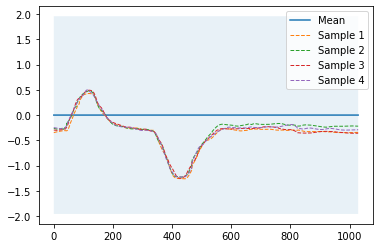

In [73]:
# Plot the GP mean, confidence interval, and samples
samples = [x_block[0], x_block[1], x_block[2], x_block[3]]
plot_gp(mu, np.diag(cov), t, samples=samples)

In [74]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_n=1e-8):
    """  
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_n: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_n**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + sigma_n * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

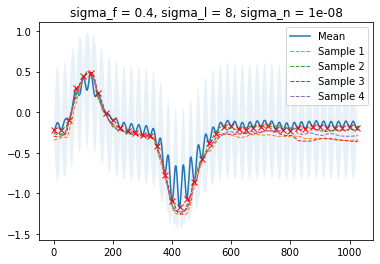

In [75]:
# get sample training points 
trn_pts = list(range(0,1030,25))

# Noise free training data
t_train = t[trn_pts]
x_train = x_block[4,trn_pts].reshape(-1,1)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(t, t_train, x_train, l=8, sigma_f=0.4)

plt.title(f'sigma_f = {0.4}, sigma_l = {8}, sigma_n = {1e-8}')
plot_gp(mu_s, np.diag(cov_s), t, X_train=t_train, Y_train=x_train, samples=samples)

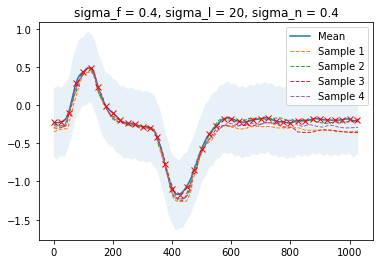

In [76]:
noise = 0.05

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(t, t_train, x_train, l=20, sigma_f=0.4, sigma_n=noise)
plt.title(f'sigma_f = {0.4}, sigma_l = {20}, sigma_n = {0.4}')
plot_gp(mu_s, np.diag(cov_s), t, X_train=t_train, Y_train=x_train, samples=samples)

## Sklearn Implementation - Global Window Hyper-parameter Training

### Optimizing x, y, and z-coordinates

In [77]:
# get training and full samples
t = np.array(range(0,1030)).reshape(-1,1)
x = blocks[0][:,0]
y = blocks[0][:,1]
z = blocks[0][:,2]

t_train = t[list(range(0,1030,25))]
x_train = x[list(range(0,1030,25))]
y_train = y[list(range(0,1030,25))]
z_train = z[list(range(0,1030,25))]

0.3861193798843898 160.0307551660923 0.6517255784719025
0.4277190230901263 65.0636382714293 0.9953985410197453


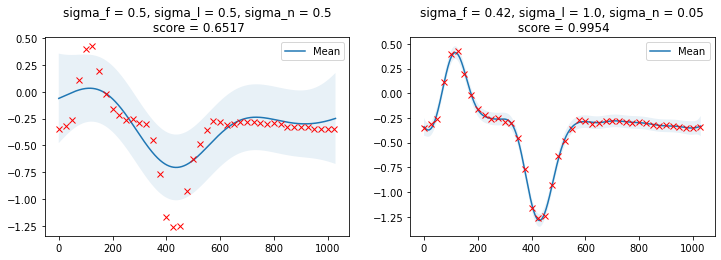

In [78]:
params = [
    (0.5, 0.5, 0.5),
    (0.42, 1.0, 0.05),
]

plt.figure(figsize=(12, 5))

for i, (sigma_f, sigma_l, sigma_n) in enumerate(params):
    mu_s, cov_s, opt_hp, score = get_pred(t, t_train, x_train, [sigma_f,sigma_l,sigma_n])
    print(opt_hp[0], opt_hp[1], score)
    
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'sigma_f = {sigma_f}, sigma_l = {sigma_l}, sigma_n = {sigma_n}\n score = {round(score,4)}')
    plot_gp(mu_s, np.diag(cov_s), t, X_train=t_train, Y_train=x_train)

1.2346310603513726 509.06240814627915 0.7525656032888073
0.9214772568899843 139.21740739630138 0.9832192090038042


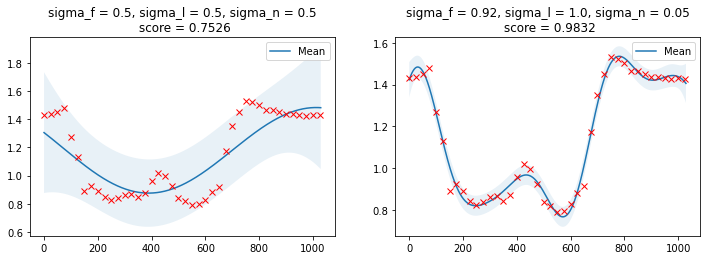

In [20]:
params = [
    (0.5, 0.5, 0.5),
    (0.92, 1.0, 0.05),
]

plt.figure(figsize=(12, 5))

for i, (sigma_f, sigma_l, sigma_n) in enumerate(params):
    mu_s, cov_s, opt_hp, score = get_pred(t, t_train, y_train, [sigma_f,sigma_l,sigma_n])
    print(opt_hp[0], opt_hp[1], score)
    
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'sigma_f = {sigma_f}, sigma_l = {sigma_l}, sigma_n = {sigma_n}\n score = {round(score,4)}')
    plot_gp(mu_s, np.diag(cov_s), t, X_train=t_train, Y_train=y_train)

1.2238722651729803 361.1943585815727 0.9172097891174287
0.9675897259869337 102.22664434852493 0.9909632262187175


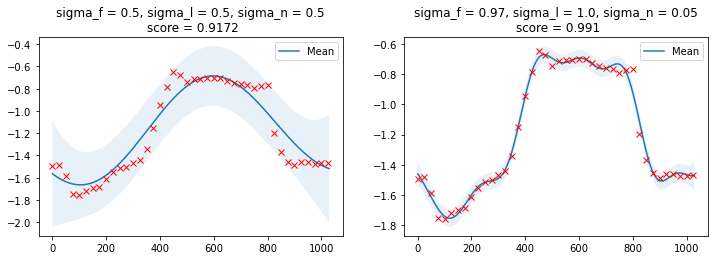

In [30]:
params = [
    (0.5, 0.5, 0.5),
    (0.97, 1.0, 0.05),
]

plt.figure(figsize=(12, 5))

for i, (sigma_f, sigma_l, sigma_n) in enumerate(params):
    mu_s, cov_s, opt_hp, score = get_pred(t, t_train, z_train, [sigma_f,sigma_l,sigma_n])
    print(opt_hp[0], opt_hp[1], score)
    
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'sigma_f = {sigma_f}, sigma_l = {sigma_l}, sigma_n = {sigma_n}\n score = {round(score,4)}')
    plot_gp(mu_s, np.diag(cov_s), t, X_train=t_train, Y_train=z_train)

### Predict sample trajectories for x, y, and z-coordinates

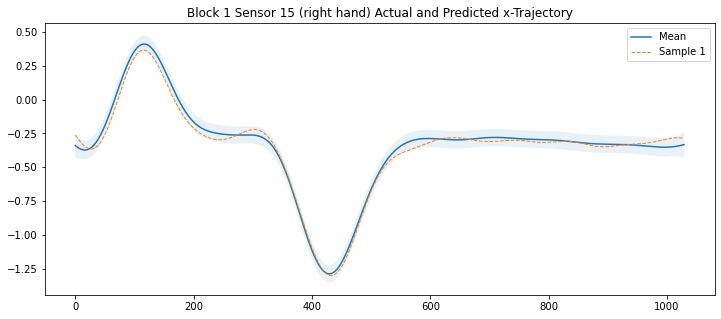

In [15]:
# x-coordinate

sigma_f = 0.42
sigma_l = 65.06
sigma_n = 0.05

rbf = ConstantKernel(sigma_f) * RBF(length_scale=sigma_l)
gpr_x = GaussianProcessRegressor(kernel=rbf, alpha=sigma_n**2, n_restarts_optimizer=8)
gpr_x.fit(t_train, x_train)
score = gpr_x.score(t_train, x_train)

# Compute posterior predictive mean and covariance
mu_x, cov_x = gpr_x.predict(t, return_cov=True)

x_sample = gpr_x.sample_y(t)
plt.figure(figsize=(12, 5))
plt.title('x-Trajectory Block 1 Sensor 15 (right hand) Actual and Predicted')
plot_gp(mu_x, np.diag(cov_x), t, samples=[x_sample])

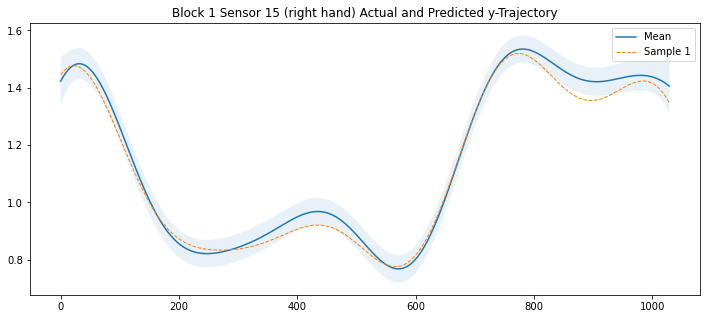

In [16]:
# y-coordinate

sigma_f = 0.92 
sigma_l = 139.22
sigma_n = 0.05

rbf = ConstantKernel(sigma_f) * RBF(length_scale=sigma_l)
gpr_y = GaussianProcessRegressor(kernel=rbf, alpha=sigma_n**2, n_restarts_optimizer=8)
gpr_y.fit(t_train, y_train)
score = gpr_y.score(t_train, y_train)

# Compute posterior predictive mean and covariance
mu_y, cov_y = gpr_y.predict(t, return_cov=True)

y_sample = gpr_y.sample_y(t)
plt.figure(figsize=(12, 5))
plt.title('y-Trajectory Block 1 Sensor 15 (right hand) Actual and Predicted')
plot_gp(mu_y, np.diag(cov_y), t, samples=[y_sample])

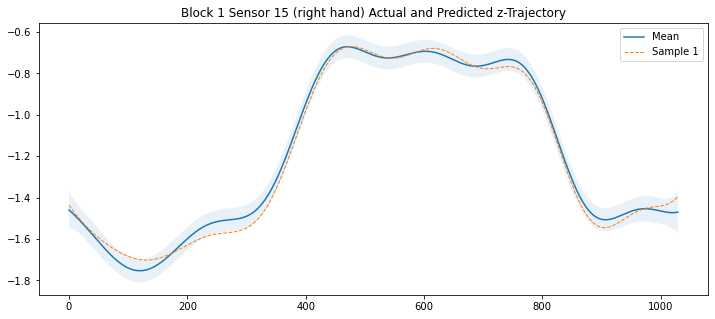

In [17]:
# z-coordinate

sigma_f = 0.97
sigma_l = 102.23
sigma_n = 0.05

rbf = ConstantKernel(sigma_f) * RBF(length_scale=sigma_l)
gpr_z = GaussianProcessRegressor(kernel=rbf, alpha=sigma_n**2, n_restarts_optimizer=8)
gpr_z.fit(t_train, z_train)
score = gpr_z.score(t_train, z_train)

# Compute posterior predictive mean and covariance
mu_z, cov_z = gpr_z.predict(t, return_cov=True)

z_sample = gpr_z.sample_y(t)
plt.figure(figsize=(12, 5))
plt.title('z-Trajectory Block 1 Sensor 15 (right hand) Actual and Predicted')
plot_gp(mu_z, np.diag(cov_z), t, samples=[z_sample])

### 3D Predicted Trajectory

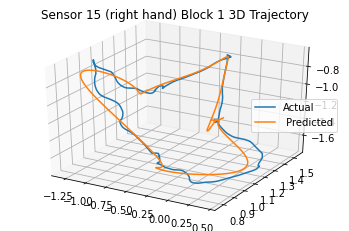

In [30]:
fig = plt.figure()
ax = fig.gca(projection='3d')

t = range(0,1030)
x = blocks[0,:,0]
y = blocks[0,:,1]
z = blocks[0,:,2]
ax.plot(x, y, z, label='Actual')

x_s = x_sample.reshape(-1)
y_s = y_sample.reshape(-1)
z_s = z_sample.reshape(-1)
ax.plot(x_s, y_s, z_s, label=' Predicted')

plt.title('Sensor 15 (right hand) Block 1 3D Trajectory')
ax.legend(loc='right')
plt.show()

## Sklearn Implementation - Sliding Window Hyper-perameter Training

In [79]:
t = np.array(range(0,1030)).reshape(-1,1)
x = blocks[0][:,0]
y = blocks[0][:,1]
z = blocks[0][:,2]

In [80]:
win_size = 102
delta = 51

sigma_f = 0.5
sigma_l = 1.0
sigma_n = 0.005

0.9775


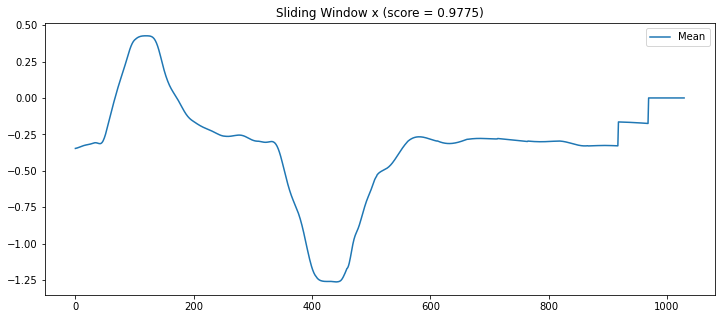

In [103]:
x_mu = np.zeros(1030)
x_cov = np.zeros(1030)

x_sigma_f_opt = []
x_sigma_l_opt = []
x_scores = []

count = 0
for lb in range(0,1020-win_size,delta):
    ub = lb + win_size
    t_win = t[lb:ub]
    y_win = x[lb:ub]

    rbf = ConstantKernel(sigma_f) * RBF(length_scale=sigma_l)
    gpr = GaussianProcessRegressor(kernel=rbf, alpha=sigma_n**2, n_restarts_optimizer=8)
    gpr.fit(t_win, y_win)
    x_scores.append(gpr.score(t_win,y_win))

    mu_s, cov_s = gpr.predict(t_win, return_cov=True)

    x_mu[lb:ub] = x_mu[lb:ub] + mu_s
    x_cov[lb:ub] = x_cov[lb:ub] + np.diag(cov_s)

    f_opt = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])
    l_opt = gpr.kernel_.k2.get_params()['length_scale']
    n_opt = np.exp(sigma_n)

#         print(f'{count+1}:\t f_opt = {round(f_opt,4)}, \t l_opt = {round(l_opt,4)}\t n_opt = {round(n_opt,4)}')

    x_sigma_f_opt.append(f_opt)
    x_sigma_l_opt.append(l_opt)
    count += 1

x_score = np.average(x_scores)
print(round(x_score,4))

# Average mean and covariance over overlapping window areas
x_mu[(win_size//2):-(win_size//2)] /= 2 
x_cov[(win_size//2):-(win_size//2)] /= 2

# Plot the results
plt.figure(figsize=(12, 5))
plt.title(f'Sliding Window x (score = {round(x_score,4)})')
plot_gp(x_mu, x_cov, t)

0.9926


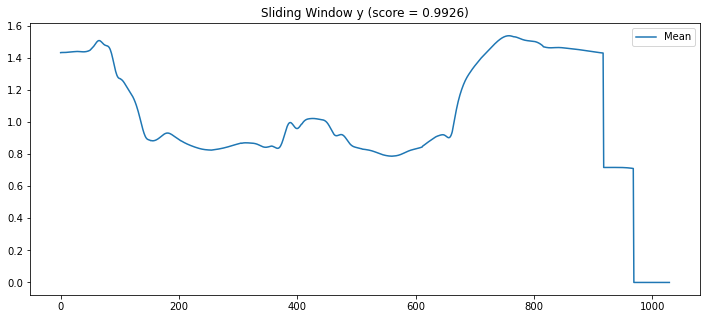

In [104]:
y_mu = np.zeros(1030)
y_cov = np.zeros(1030)

y_sigma_f_opt = []
y_sigma_l_opt = []
y_scores = []

count = 0
for lb in range(0,1020-win_size,delta):
    ub = lb + win_size
    t_win = t[lb:ub]
    y_win = y[lb:ub]

    rbf = ConstantKernel(sigma_f) * RBF(length_scale=sigma_l)
    gpr = GaussianProcessRegressor(kernel=rbf, alpha=sigma_n**2, n_restarts_optimizer=8)
    gpr.fit(t_win, y_win)
    y_scores.append(gpr.score(t_win,y_win))

    mu_s, cov_s = gpr.predict(t_win, return_cov=True)

    y_mu[lb:ub] = y_mu[lb:ub] + mu_s
    y_cov[lb:ub] = y_cov[lb:ub] + np.diag(cov_s)

    f_opt = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])
    l_opt = gpr.kernel_.k2.get_params()['length_scale']
    n_opt = np.exp(sigma_n)

#         print(f'{count+1}:\t f_opt = {round(f_opt,4)}, \t l_opt = {round(l_opt,4)}\t n_opt = {round(n_opt,4)}')

    y_sigma_f_opt.append(f_opt)
    y_sigma_l_opt.append(l_opt)
    count += 1

y_score = np.average(y_scores)
print(round(y_score,4))

# Average mean and covariance over overlapping window areas
y_mu[(win_size//2):-(win_size//2)] /= 2 
y_cov[(win_size//2):-(win_size//2)] /= 2

# Plot the results
plt.figure(figsize=(12, 5))
plt.title(f'Sliding Window y (score = {round(y_score,4)})')
plot_gp(y_mu, y_cov, t)

0.9864


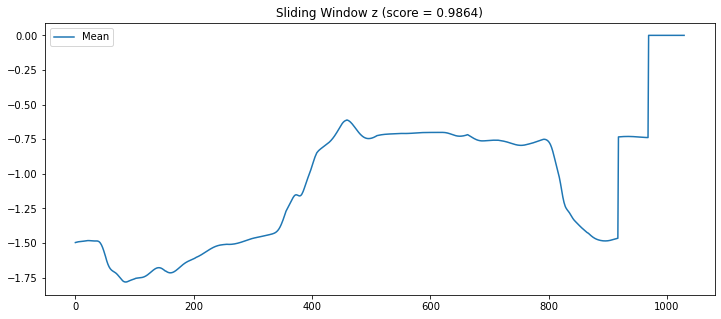

In [105]:
z_mu = np.zeros(1030)
z_cov = np.zeros(1030)

z_sigma_f_opt = []
z_sigma_l_opt = []
z_scores = []

count = 0
for lb in range(0,1020-win_size,delta):
    ub = lb + win_size
    t_win = t[lb:ub]
    y_win = z[lb:ub]

    rbf = ConstantKernel(sigma_f) * RBF(length_scale=sigma_l)
    gpr = GaussianProcessRegressor(kernel=rbf, alpha=sigma_n**2, n_restarts_optimizer=8)
    gpr.fit(t_win, y_win)
    z_scores.append(gpr.score(t_win,y_win))

    mu_s, cov_s = gpr.predict(t_win, return_cov=True)

    z_mu[lb:ub] = z_mu[lb:ub] + mu_s
    z_cov[lb:ub] = z_cov[lb:ub] + np.diag(cov_s)

    f_opt = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])
    l_opt = gpr.kernel_.k2.get_params()['length_scale']
    n_opt = np.exp(sigma_n)

#         print(f'{count+1}:\t f_opt = {round(f_opt,4)}, \t l_opt = {round(l_opt,4)}\t n_opt = {round(n_opt,4)}')

    z_sigma_f_opt.append(f_opt)
    z_sigma_l_opt.append(l_opt)
    count += 1

z_score = np.average(z_scores)
print(round(z_score,4))

# Average mean and covariance over overlapping window areas
z_mu[(win_size//2):-(win_size//2)] /= 2 
z_cov[(win_size//2):-(win_size//2)] /= 2

# Plot the results
plt.figure(figsize=(12, 5))
plt.title(f'Sliding Window z (score = {round(z_score,4)})')
plot_gp(z_mu, z_cov, t)

In [106]:
print(round(np.average(x_sigma_f_opt),4))
print(round(np.average(x_sigma_l_opt),4))

print(round(np.average(y_sigma_f_opt),4))
print(round(np.average(y_sigma_l_opt),4))

print(round(np.average(z_sigma_f_opt),4))
print(round(np.average(z_sigma_l_opt),4))

0.3422
65.18
0.8059
68.2706
0.8217
67.2938
